In [1]:
import os
import sys
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn as nn
from torch.optim.optimizer import Optimizer
from torch.utils.tensorboard import SummaryWriter

# configure module & syspath
module_path = os.path.abspath(os.path.join('../../../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.maml.supervised.models import SinusoidMLP

In [2]:
class SineWave:

    def __init__(self, amplitude: float, phase: float):
        """
        Initialize amplitude sine wave
        Args:
          amplitude (int): Amplitude for the Sine wave.
          phase (phase): Phase for the Sine wave function.
        """
        self.amplitude = amplitude
        self.phase = phase

    def sample(self, num_points: int) -> [list, list]:
        """
        Sample a given number of points from the current Sine wave function.
        Args:
          num_points (int): Number of points to sample from the
        Returns:
          Returns an tuple with the x and y coordinates of the sampled points.
        """
        x = torch.rand((num_points, 1)) * 10 - 5
        y = self.amplitude * torch.sin(x + self.phase)

        return x, y

In [3]:
device = 'cpu'
plt.rcParams['figure.figsize'] = (10, 4)

In [4]:
@torch.no_grad()
def generate_task() -> SineWave:
    """
    Samples amplitude and phase, then returns a Sine Wave function corresponding to it.

    Returns:
        Returns a neural network that is tuned for few-shot learning.
    """
    amp = torch.rand(1).item() * 4.9 + 0.1
    phase = torch.rand(1).item() * np.pi

    return SineWave(amp, phase)

In [5]:
def MAML(
  num_training_epochs: int,
  num_tasks: int,
  k_train: int,
  k_test: int,
  learning_rate: float,
  device: str
):
    """
    Runs MAML on in the supervised regression setting as described in the MAML paper.

    Args:
        num_training_epochs (int): The number of epochs to run MAML over.
        num_tasks (int): Number of tasks to be sampled from the distribution (same as the batch size).
        sample_size_k (int): The number of samples to be used for each of the tasks.
        learning_rate (float): Learning rate to be used for the optimizers.
        device (str): Device to run MAML on (can either be set to CPU or GPU)

    Returns:
        Returns a neural network that is tuned for few-shot learning.
    """
    
    """
    @todo check if the MAML algorithm can be further broken down, how much of this can be reused for classificaiton / reinforcement learning.
    @todo check if the learning rates for internal and meta updates should be different.
    """

    meta_model = SinusoidMLP(input_dim=1, hidden_dim=40, output_dim=1).to(device)
    meta_optim = torch.optim.Adam(meta_model.parameters(), lr=learning_rate)

    writer = SummaryWriter()
    training_loss = list()
    inner_training_loops = 1

    for current_epoch in tqdm(range(num_training_epochs)):
        theta_prime = dict()
        data_prime = dict()
        
        """
        Sample tasks from the distribution, create a batch.
        """
        regression_tasks = [generate_task() for _ in range(num_tasks)]

        """
        Iterate over each task in order to:
            - Evaluate with respect to K examples
            - Compute adapted parameters with gradient descent.
        """
        for i, task in enumerate(regression_tasks):
            # sample "K-train" points from the current task.
            x_batch, y_batch = task.sample(k_train)

            # clone the model and optimize it for a specific task.
            model_copy = SinusoidMLP(input_dim = 1, hidden_dim = 40, output_dim = 1)
            model_copy.load_state_dict(meta_model.state_dict())
            model_copy.to(device)

            local_optim = torch.optim.SGD(model_copy.parameters(), lr=learning_rate)

            for _ in range(inner_training_loops):
                """
                Sample k points from a task, evaluate loss with respect to K examples.
                """
                loss_function = nn.MSELoss()
                loss = loss_function(model_copy(x_batch.to(device)), y_batch.to(device))

                """
                Compute adapted parameters with gradient descent.
                """ 
                local_optim.zero_grad()
                loss.backward()
                local_optim.step()
                continue

            """
            For the meta-update, we need to:
                - Track adapted parameter "theta prime".
                - Sample additional data from the current task that will be used to check out-of-sample performance.
            """
            theta_prime[i] = model_copy.state_dict()

            # @todo check if this update makes a large difference.
            x_prime_batch, y_prime_batch = task.sample(k_test)
            data_prime[i] = (x_prime_batch, y_prime_batch)
            pass

        """
        While making the meta-update:
            - Sample data points for each task.
            - Compute loss for each of the "theta prime" parameters.
            - Aggregate gradients for losses corresponding to each "theta prime".
        """
        meta_optim.zero_grad()
        meta_grads = [torch.zeros_like(p) for p in meta_model.parameters()]
        batch_training_loss = list()

        for i, _ in enumerate(regression_tasks):
            x_prime_batch, y_prime_batch = data_prime[i]

            model_theta_prime = SinusoidMLP(input_dim = 1, hidden_dim = 40, output_dim = 1).to(device)
            model_theta_prime.load_state_dict(theta_prime[i])
            loss_function = nn.MSELoss()

            """
            Compute out-of-sample loss for each of the tasks.
            """
            loss = loss_function(model_theta_prime(x_prime_batch.to(device)), y_prime_batch.to(device))
            loss.backward()

            batch_training_loss.append(loss.item())

            """
            Then, aggregate the gradients.
            """
            for grad, param in zip(meta_grads, model_theta_prime.parameters()):
                grad += param.grad

        """
        Update parameter updates using aggregated gradients.
        """
        for param, grad in zip(meta_model.parameters(), meta_grads):
            param.grad = grad
            pass

        meta_optim.step()
        training_loss.append(np.mean(batch_training_loss))
        writer.add_scalar('meta-loss-sinusoid', np.mean(batch_training_loss), current_epoch)
        
        if current_epoch % 500 == 0:
            writer.flush()

    writer.close()

    return meta_model, training_loss

In [6]:
meta_model, training_loss = MAML(
    num_training_epochs=70000, 
    num_tasks=10,
    k_train=10, 
    k_test=25,
    learning_rate=1e-3, 
    device=device 
)

100%|██████████| 70000/70000 [43:12<00:00, 27.00it/s]  


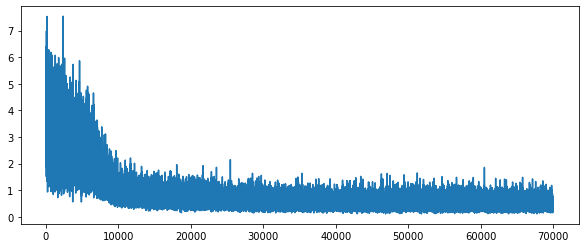

In [7]:
plt.plot(training_loss)

In [17]:
def k_shot_tune(model, task, k_shot, gradient_steps, alpha, device='cpu'):
    optimizer = torch.optim.SGD(model.parameters(), lr=alpha)
    x_batch, target = task.sample(k_shot)
    loss_fct = nn.MSELoss()

    for epoch in range(gradient_steps):
        loss = loss_fct(model(x_batch.to(device)), target.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model

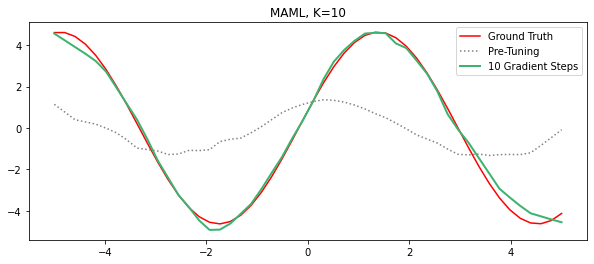

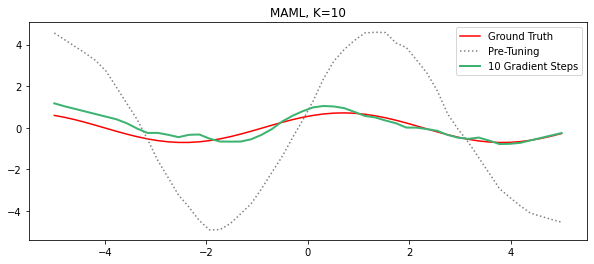

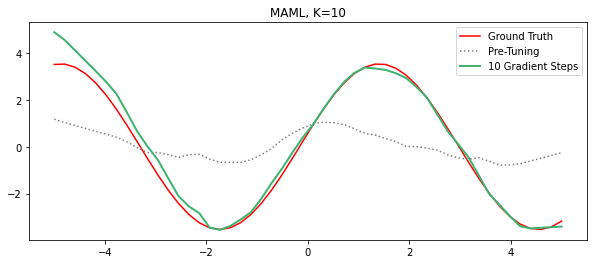

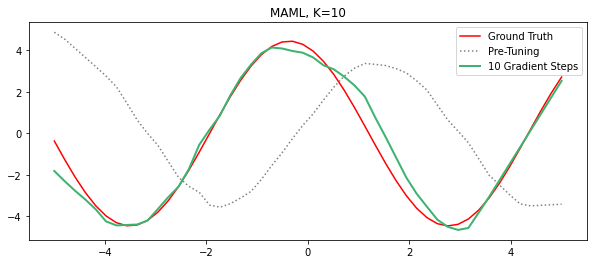

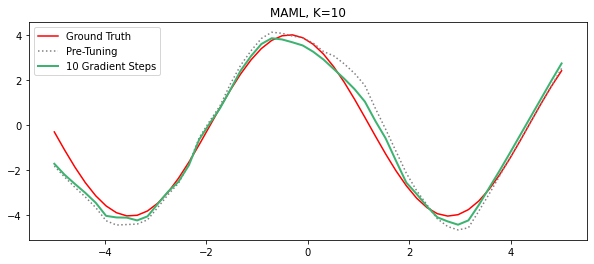

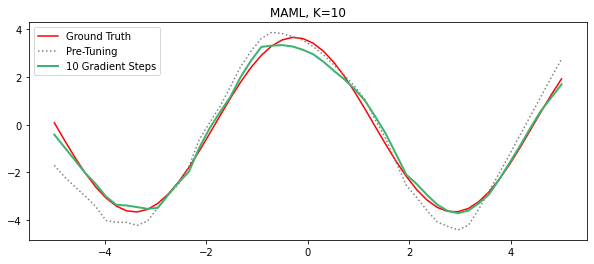

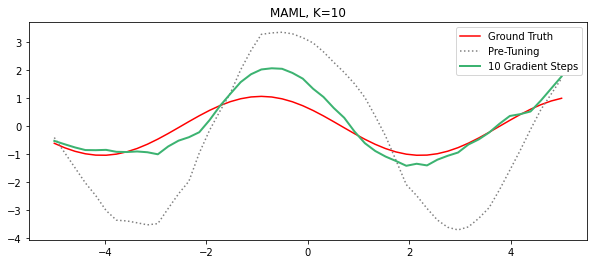

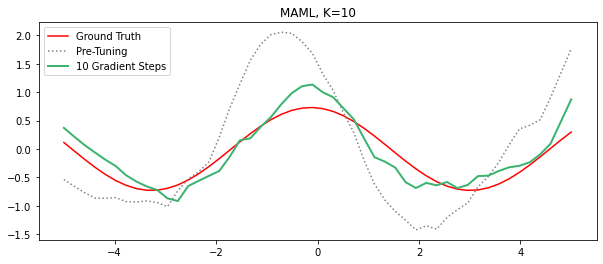

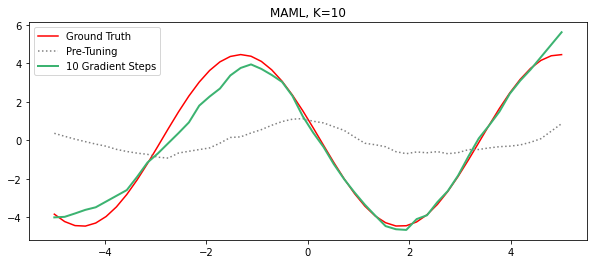

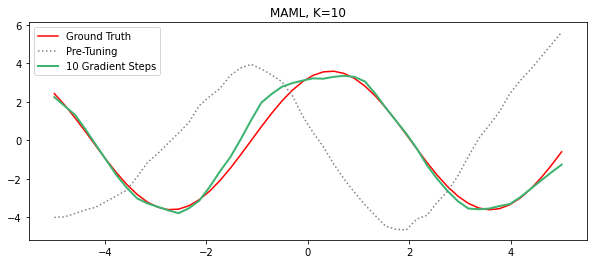

In [18]:
for i in range(10):
    x = torch.linspace(-5, 5, 50)
    task = generate_task()
    ground_truth_y = task.amplitude * torch.sin(x + task.phase)
    pre_tuning_y = meta_model(x[..., None])

    # Tune
    tuned_model = k_shot_tune(meta_model, task, k_shot = 10, gradient_steps = 10, alpha = 1e-3, device='cpu')
    y = tuned_model(x[..., None])

    # Plot
    plt.title('MAML, K=10')
    plt.plot(x.data.numpy(), ground_truth_y.data.numpy(), c='red', label='Ground Truth')
    plt.plot(x.data.numpy(), pre_tuning_y.data.numpy(), c='gray', linestyle='dotted', label='Pre-Tuning')
    plt.plot(x.data.numpy(), y.data.numpy(), c='mediumseagreen', label='10 Gradient Steps', linewidth='2')
    plt.legend()
    plt.show()